In [1]:
import os
import joblib
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay
)

In [2]:
data_dir = r"D:\Big Data Alzheimer Prediction Project\Alzheimer-Prediction-System\outputs\preprocessed"

X_train = joblib.load(os.path.join(data_dir, "X_train.pkl"))
X_val   = joblib.load(os.path.join(data_dir, "X_val.pkl"))
X_test  = joblib.load(os.path.join(data_dir, "X_test.pkl"))
y_train = joblib.load(os.path.join(data_dir, "y_train.pkl"))
y_val   = joblib.load(os.path.join(data_dir, "y_val.pkl"))
y_test  = joblib.load(os.path.join(data_dir, "y_test.pkl"))

print("Data loaded successfully!")

Data loaded successfully!


In [3]:
def evaluate_model(model, X_val, y_val, model_name="Model"):
    start_pred = time.time()
    y_pred = model.predict(X_val)
    end_pred = time.time()

    metrics = {
        "Accuracy": accuracy_score(y_val, y_pred),
        "Precision": precision_score(y_val, y_pred),
        "Recall": recall_score(y_val, y_pred),
        "F1 Score": f1_score(y_val, y_pred),
        "ROC-AUC": roc_auc_score(y_val, y_pred),
        "Prediction Time (s)": end_pred - start_pred
    }

    print(f"\n📊 {model_name} Evaluation Results:")
    print(pd.DataFrame(metrics, index=[0]))
    print("\nClassification Report:\n", classification_report(y_val, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC curve
    RocCurveDisplay.from_estimator(model, X_val, y_val)
    plt.title(f"{model_name} - ROC Curve")
    plt.show()

    return metrics

In [4]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 1]
}

xgb = XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=2
)

start_train = time.time()
grid_search.fit(X_train, y_train)
end_train = time.time()

print("\nGrid Search Complete!")
print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

Fitting 5 folds for each of 144 candidates, totalling 720 fits

🏁 Grid Search Complete!
Best Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Best CV Score: 0.929007765086264


D:\Big Data Alzheimer Prediction Project\Alzheimer-Prediction-System\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:57:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 XGBoost Evaluation Results:
   Accuracy  Precision   Recall  F1 Score   ROC-AUC  Prediction Time (s)
0  0.935252   0.950495  0.91866  0.934307  0.935292             0.007234

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.95      0.94       208
           1       0.95      0.92      0.93       209

    accuracy                           0.94       417
   macro avg       0.94      0.94      0.94       417
weighted avg       0.94      0.94      0.94       417



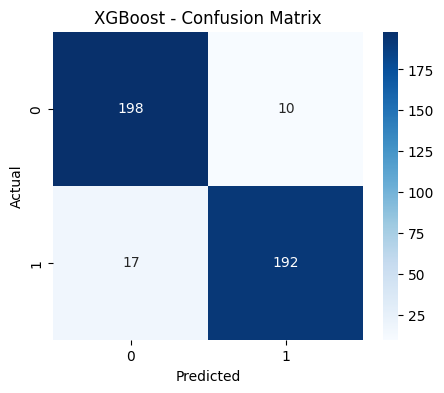

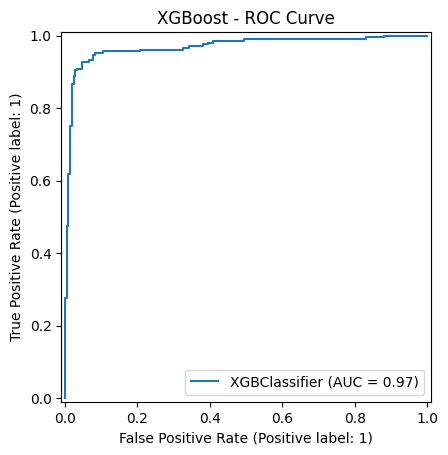

In [5]:
best_xgb = grid_search.best_estimator_
metrics = evaluate_model(best_xgb, X_val, y_val, "XGBoost")

metrics["Training Time (s)"] = end_train - start_train
metrics["Best Params"] = grid_search.best_params_

In [7]:
model_path = r"D:\Big Data Alzheimer Prediction Project\Alzheimer-Prediction-System\models\outputs"
results_path = r"D:\Big Data Alzheimer Prediction Project\Alzheimer-Prediction-System\outputs\model_results"

os.makedirs(model_path, exist_ok=True)
os.makedirs(results_path, exist_ok=True)

joblib.dump(best_xgb, os.path.join(model_path, "xgboost_model.pkl"))
pd.DataFrame([metrics]).to_csv(os.path.join(results_path, "xgboost_results.csv"), index=False)

print("\nXGBoost model and results saved successfully!")


XGBoost model and results saved successfully!
